In [1]:
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline

import matplotlib.pyplot as plt

In [38]:
planets = pd.read_csv('exoplanets.csv')
planets.shape

(517, 6)

## Approximate Inference and Sampling, Part 1

### Why Inference is hard

In simple models like our product review model or our model for heights, it was easy to compute the exact posterior for the unknown variable that we were interested in. This happened because we chose a conjugate prior. In most other cases, computing the exact posterior is hard! Here are two examples:

#### One-dimensional non-conjugate prior

Suppose our observations are binary, but instead of a Beta prior, we choose $p(\theta) = \frac{2}{\pi}\cos\left(\frac{\pi}{2} \theta\right)$ for $\theta \in [0, 1]$. 


$$
\begin{align}
p(\theta|x) 
    &\propto p(x|\theta)p(\theta) \\
    &\propto \Big[\theta^{\left[\sum_i x_i\right]}(1-\theta)^{\left[\sum_i (1-x_i)\right]}\Big]\cos\left(\frac{\pi}{2}\theta\right)
\end{align}
$$

This distribution looks much more complicated: we can't reduce it to a known distribution at all. So, in order to properly compute $p(\theta|x)$, we'd need to figure out the normalizing constant. This requires solving the integral:

$$
\begin{align}
\int_0^1 \Big[\theta^{\left[\sum_i x_i\right]}(1-\theta)^{\left[\sum_i (1-x_i)\right]}\Big]\cos\left(\frac{\pi}{2}\theta\right)\,d\theta
\end{align}
$$

This integral is difficult to solve in closed form. But, there are still some things we can do with it. In particular, we can still compute the MAP estimate, because when maximizing $p(\theta|x)$, we don't care about the normalizing constant. Unfortunately, we can't compute the LMSE (mean of the posterior distribution), or any other quantities such as the variance. Recall that the LMSE in this case is $\int_0^1 \theta p(\theta|x)\,d\theta$: in order to accurately compute this integral, we need the normalizing constant.

There is one trick we can use for the posterior of a single variable: numerical integration. For a particular sequence of values $x_1, \ldots, x_n$, we can compute a numerical approximation to the integral, and find the normalizing constant this way. 

#### Multi-dimensional example

Consider the exoplanet model from last time: $x_i$ is the (observed) radius of planet $i$, $z_i$ is whether the planet belongs to group 0 (small, possibly habitable planets) or group 1 (large, possibly inhabitable planets), and $\mu_0$ and $\mu_1$ are the mean radii of those two groups, respectively.

$$
\begin{align}
    z_i &\sim \mathrm{Bernoulli}(\pi) & i = 1, \ldots, n \\
    \mu_k &\sim \mathcal{N}(\mu_p, \sigma_p) &  k =0, 1 \\
    x_i | z_i, \mu_0, \mu_1 &\sim \mathcal{N}(\mu_{z_i}, \sigma) & i = 1, \ldots, n\\
\end{align}
$$

We can write the likelihood and prior. To simplify, we'll write $\mathcal{N}(y; m, s) = \frac{1}{s \sqrt{2\pi}} \exp\left\{-\frac{1}{2s^2}(y - m)^2\right\}$

$$
\begin{align}
    p(z_i) &= \pi^{z_i}(1-\pi)^{1-z_i} \\
    p(\mu_k) &= \mathcal{N}(\mu_k; \mu_p, \sigma_p) \\
    p(x_i | z_i, \mu_0, \mu_1) &= \mathcal{N}(x_i; \mu_{z_i}, \sigma)
\end{align}
$$

We can try computing the posterior over the hidden variables $z_i$, $\mu_0$, and $\mu_1$. We'll use the notation $z_{1:n}$ to represent $z_1, \dots, z_n$ (and similarly for $x_{1:n}$).

$$
\begin{align}
    p(z_{1:n}, \mu_0, \mu_1 | x_{1:n}) &\propto p(\mu_0)p(\mu_1)\prod_i \left[p(z_i) p(x_i | z_i, \mu_0, \mu_1)\right]
\end{align}
$$

This distribution is more complicated than anything we've seen up until now. It's the joint distribution over $n+2$ random variables (the group labels $z_1, \ldots, z_n$ and the two group means $\mu_0$ and $\mu_1$).

Computing the normalization constant $p(x_{1:n})$ requires a complicated combination of sums and integrals:

$$
p(x_{1:n}) = \sum_{z_1=0}^1 \sum_{z_2=0}^1 \ldots \sum_{z_n=0}^1 \int \int p(\mu_0)p(\mu_1)\prod_i \left[p(z_i) p(x_i | z_i, \mu_0, \mu_1)\right]
$$

For our dataset of over 500 planets, the sum alone would require a completely intractable amount of computation:

In [39]:
2**517

429049853758163107186368799942587076079339706258956588087153966199096448962353503257659977541340909686081019461967553627320124249982290238285876768194691072

Worse still, we can't even compute the MAP estimate for the labels $z_i$: in order to find the one that maximizes the numerator, we'd have to search over all $2^{517}$ combinations, which is also completely intractable. 

Even in this fairly simple model, with two groups, we've found that exact inference is completely hopeless: there's no way we can compute the exact posterior for all our unknowns. In the rest of this notebook, we'll talk about ways to get around this problem using approximations to the posterior distribution.

## Rejection Sampling

As a warmup, let's suppose that we want to sample a pair of random variables ($x_1$, $x_2$) drawn uniformly from the unit circle. In other words, we want the uniform distribution over the blue region below:

How can we go about doing this? 

*(Hint: first sample uniformly over the unit square.)*

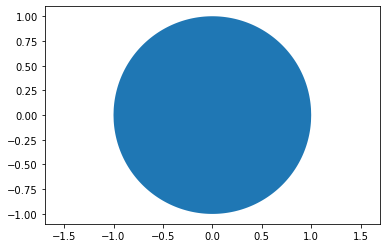

In [3]:
x_ = np.linspace(-1, 1, 1000)
semicircle = np.sqrt(1-x_**2)
plt.fill_between(x_, -semicircle, semicircle)
plt.axis('equal');

Variance of x1 (estimated from samples): 0.271


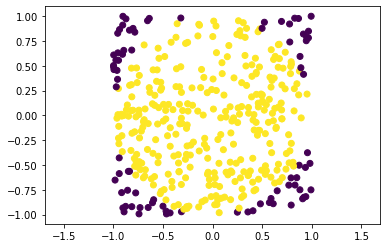

In [4]:

# Number of samples
N = 400

# Samples in the unit square
samples = (np.random.random([N, 2]) - 0.5) * 2

# Which ones are inside the unit circle?
is_in_circle = (samples[:,0]**2 + samples[:, 1]**2) < 1

plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], c=(is_in_circle + 2.0))
plt.axis('equal')

good_samples = samples[is_in_circle]
x1 = good_samples[:, 0]
x2 = good_samples[:, 1]
print('Variance of x1 (estimated from samples): %.3f' % np.var(x1))

In [5]:
import seaborn as sns
sns.set()

Next, let's think about sampling from a distribution with a complicated density. Suppose we want to sample from the distribution with density $p(\theta|x) \propto \theta \cdot (1.5-\theta) \cdot \sin(\theta)$ for $\theta \in [0,1.5]$:

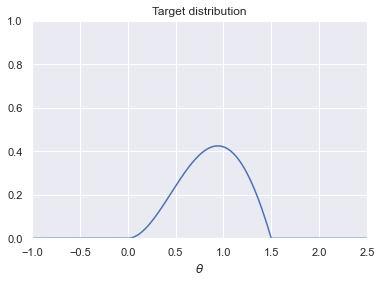

In [6]:
t = np.linspace(-1, 2.5, 500)
def target(t):
    """The unnormalized distribution we want to sample from"""
    return t * (1.5-t) * np.sin(t) * ((t > 0) & (t < 1.5))
plt.plot(t, target(t))
plt.title('Target distribution')
plt.xlabel(r'$\theta$')
plt.axis([-1,2.5,0,1])
plt.show()

How can we make this look like the geometric example from before? Idea: "lifting" (add one dimension).

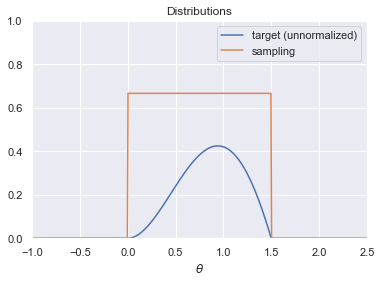

In [7]:
x = np.linspace(-1, 2.5, 500)
def uniform_sampling_dist(t):
    """PDF of distribution we're sampling from: Uniform[0, 1.5]"""
    return stats.uniform.pdf(t, 0, 1.5)

plt.plot(t, target(t), label='target (unnormalized)')
plt.plot(t, uniform_sampling_dist(t), label='sampling')
plt.axis([-1,2.5,0,1])
plt.legend()
plt.title('Distributions')
plt.xlabel(r'$\theta$')
plt.show()

In [8]:
def rejection_sample_uniform(num_samples=100):
    # Generate proposals for samples: these are θ-values.
    # We'll keep some and reject the rest.
    proposals = np.random.uniform(low=0, high=1.5, size=num_samples)
    
    # Acceptance probability is the ratio of the two curves
    # These had better all be between 0 and 1!
    accept_probs = target(proposals) / uniform_sampling_dist(proposals)
    
    print('Max accept prob: %.3f' % np.max(accept_probs))
    
    # For each sample, we make a decision whether or not to accept.
    # Convince yourself that this line makes that decision for each
    # sample with prob equal to the value in "accept_probs"!
    accept = np.random.uniform(size=num_samples) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]


Max accept prob: 0.638
Accepted 20 out of 50 proposals


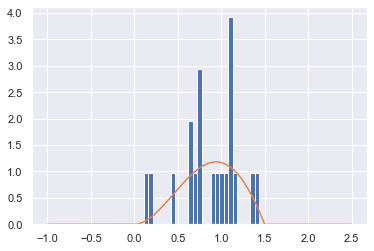

In [9]:
samples = rejection_sample_uniform(num_samples=50)

# Plot a true histogram (comparable with density functions) using density=True
plt.hist(samples, bins=np.linspace(-0.5, 2, 50), density=True)

# Where did this magic number 0.36 come from? What happens if you change it?
plt.plot(t, target(t) / 0.36)


As a final example, what happens if we want to sample across the entire real line? For instance, suppose our density is $p(\theta|x) \propto \exp(-\theta) |\sin(2\theta)|$ for $\theta \in [0, \infty)$. We certainly can't use a uniform proposal distribution, but using the exponential distribution works just fine.

Accepted 61 out of 100 proposals


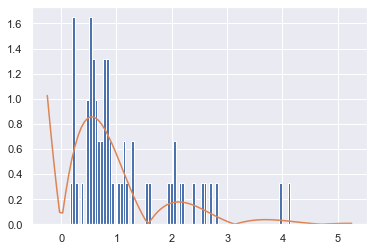

In [11]:
def decaying_target_distribution(t):
    """Unnormalized target distribution as described above"""
    return np.exp(-t) * np.abs(np.sin(2*t))

def sampling_distribution_exponential(t):
    """Sampling distribution: exponential distribution"""
    # stats.expon has a loc parameter which says how far to shift
    # the distribution from its usual starting point of θ=0
    return stats.expon.pdf(t, loc=0, scale=1.0)

def rejection_sample_exponential(num_samples=100):
    proposals = np.random.exponential(scale=1.0, size=num_samples)
    
    accept_probs = decaying_target_distribution(proposals) / sampling_distribution_exponential(proposals)
    accept = np.random.uniform(0, 1, num_samples) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]
samples = rejection_sample_exponential(num_samples=100)
plt.hist(samples, bins=np.linspace(0, 5, 100), density=True)
# Find how far the axis goes and draw the unnormalized distribution over it

tmin, tmax, _, _ = plt.axis()
t_inf = np.linspace(tmin, tmax, 100)

# Where did this magic number 0.6 come from? What happens if you change it?
plt.plot(t_inf, decaying_target_distribution(t_inf) / 0.6)
plt.show()

## Implementing models in PyMC3

Let's go back to the simple review model:

$$
\begin{align}
    x_i &\sim \mathrm{Bernoulli}(\theta) \\
    \theta &\sim \mathrm{Beta}(\alpha, \beta)
\end{align}
$$

Is there a way to implement this model computationally and have Python do all the work of inference for us? It turns out the answer is yes!


In [12]:
reviews_a = np.array([1, 1, 1])
reviews_b = np.array([1] * 19 + [0])

In [30]:
import pymc3 as pm
import arviz as az

# Parameters of the prior
alpha = 1
beta = 5

with pm.Model() as model:
    # Defines a Beta-distributed random variable called theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta)
    
    # Defines a Bernoulli RV called x. Since x is observed, we
    # pass in the observed= argument to provide our data
    x = pm.Bernoulli('x', p=theta, observed=reviews_b)
    
    # This line asks PyMC3 to approximate the posterior.
    # Don't worry too much about how it works for now.
    trace = pm.sample(2000, chains=2, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.


In [31]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [32]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    theta    (chain, draw) float64 0.7162 0.5931 0.6991 ... 0.6372 0.6829 0.6829
Attributes:
    created_at:                 2022-02-10T17:15:54.666810
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              13.34704875946045
    tuning_steps:               1000

In [33]:
thetas = trace.posterior['theta'].values.flatten()
thetas

array([0.71624896, 0.59305272, 0.69909168, ..., 0.63719325, 0.68287791,
       0.68287791])

(array([1.000e+00, 6.000e+00, 2.500e+01, 9.700e+01, 3.060e+02, 7.220e+02,
        1.129e+03, 1.108e+03, 5.350e+02, 7.100e+01]),
 array([0.35754272, 0.41899383, 0.48044493, 0.54189604, 0.60334715,
        0.66479826, 0.72624937, 0.78770048, 0.84915159, 0.9106027 ,
        0.97205381]),
 <BarContainer object of 10 artists>)

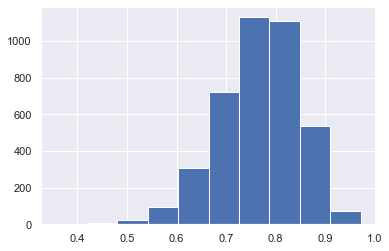

In [34]:
plt.hist(thetas)

Let's try a more interesting model: our mixture model for exoplanets:

$$
\begin{align}
    z_i &\sim \mathrm{Bernoulli}(\pi) & i = 1, \ldots, n \\
    \mu_k &\sim \mathcal{N}(\mu_p, \sigma_p) &  k =0, 1 \\
    x_i | z_i, \mu_0, \mu_1 &\sim \mathcal{N}(\mu_{z_i}, \sigma) & i = 1, \ldots, n\\
\end{align}
$$

First, we'll need a trick called "fancy indexing". Here's how it works:

In [35]:
example_zs = np.array([1, 0, 0, 1, 1, 0])
example_mus = np.array([1.3, 10.2])

means = example_mus[example_zs]
means

array([10.2,  1.3,  1.3, 10.2, 10.2,  1.3])

In [41]:
pi = 0.4  # Prior probability of a planet being in the large/uninhabitable group
sigma = 1.5  # SD of likelihood
mu_p = 5  # Mean of prior
sigma_p = 10  # Variance of prior: important to choose a large value here

with pm.Model() as model_exoplanet:
    
    # This defines a Bernoulli random variable called 'z' in our model.
    z = pm.Bernoulli('z', p=pi)
    
    # This creates an array of two random variables called 'mu'
    # (one for each group), because we used the shape=2 argument
    mu = pm.Normal('mu', mu=mu_p, sigma=sigma_p, shape=2)

    planet_means = mu[z]
    # this is the tricky bit with the indexing , but it'll be easy if they can 
    # pattern match to a GMM code example or some other example we link them to
    x = pm.Normal('x', mu=planet_means, sigma=sigma, observed=planets['radius'])
    
    trace_exoplanet = pm.sample(2000, chains=2, tune=1000, return_inferencedata=True)
    
    

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [z]
>NUTS: [mu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [46]:
trace_exoplanet.posterior['mu']

<xarray.DataArray 'mu' (chain: 2, draw: 2000, mu_dim_0: 2)>
array([[[  9.79029691,  -7.05342481],
        [  9.82436778, -10.7688198 ],
        [  9.78095979,  12.01222035],
        ...,
        [  9.77061438,   2.56897033],
        [  9.88131872,  11.50045539],
        [  9.8842656 ,  19.18546817]],

       [[  0.7144112 ,   9.80094943],
        [  2.34307326,   9.77018607],
        [  4.82818226,   9.69658414],
        ...,
        [  3.46040662,   9.78832372],
        [  0.6052693 ,   9.81095172],
        [  3.35958841,   9.82835076]]])
Coordinates:
  * chain     (chain) int64 0 1
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * mu_dim_0  (mu_dim_0) int64 0 1